In [2]:
## Your grade: 4.5

# SLT-CE-5: Constant Shift Embedding

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

 <h2 style="background-color:#f0b375;"> Setup </h2>

We start by importing necessary python packages.

In [358]:
import numpy as np
import numpy as geek
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA
from sklearn.cluster import KMeans


import scipy.linalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

# Fix randoom seed for reproducibility
np.random.seed(42)

The number of nodes is hardcoded for simplicity (taken from [2]):

In [359]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [360]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1


Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [206]:
class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        self.PMAT = DATA
        self.D = D
        self.nodes = nodes
        # Add/change parameters, if necessary.
    
    def fit(self, PMAT, nodes ):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """

        # Save data
        self.PMAT = PMAT
        # calculating the number of people i will use it
        self.nodes = nodes
        #NUM_NODES
        D = np.zeros((nodes, nodes))
        norm = nodes
        # then for each subject, I compare the number of disimilarities between the other
        #subjects, the colums (1004). Ex. if a= [1 0 1] and b=[0 1 1], we get 2 similarities
        #and thye are normalized to the number of people that a peron contacted it.
        # Since it is 0 and 1s, it is equivalent to a xor
        # this asures the diagonal of D is 0 and the rest shows the true pairwise disimilarities
    
        
        for i in range(0,nodes):
            person1 = DATA[i,:]
            
            for j in range(0,nodes):
                person2 = DATA[j,:]
                d = person1*(1-person2) + (1-person1)*person2 #do xor
                D[i,j] = sum(d)/norm
        
        return D
        
     
        
        
    def get_embedded_vectors(self, D, nodes):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        #inizializing unit matrices and unit vectors
        self.D = D
        self.nodes = nodes
        D = np.matrix(D)
        e = np.ones((1,nodes))
        I = geek.identity(nodes, dtype = float) 
        I = np.matrix(I)
        
        #Centralized D
        Dsym = 0.5 * (D + np.transpose(D)) 
        # similariy matrix
        Sc = -0.5 * Dsym
        #Eigendescompostion of the centralized similarity matrix
        w, v = LA.eig(Sc)
        #Eigenvalues of the centralized similarity matrix
        w2 = np.abs(w)
       
        #Calculate Dtilde
        Dtilde = Dsym - 2 * w *(e  *  np.transpose(e) - I)
        Q = I -(1/nodes)*(e * np.transpose(e))
        Stilde = -0.5 * Q * Dtilde * Q
        #######
        #due to the centralization which introuces a linear dependecny between  all vectors.
        #at least one eigenvalue equals zero, i.e, p < n-1
        #starting eigen descmposition of Stilde
        
        wtilde, vtilde = LA.eig(Stilde)

        #had to use a positive to avoid getting complex Xp
        wtilde1 = np.abs(wtilde)
        ## FL: you should not get complex eigenvalues. Symmetrice matrix before.
        

        #eigenbasis
        trianguloinvertido = np.zeros((nodes,nodes), float)

        #filling the diagonal with the eigenvalues for Stilde to have delta_p
        np.fill_diagonal(trianguloinvertido, wtilde1)
        
        #checking
        Arara = v * trianguloinvertido * np.transpose(v)
       
        #calulation Xp (eq.16) 
        #rows contain in p dimensional space in p dimensional space.
        #mutual distances are given in Dtilde
        Xp = v * np.sqrt(trianguloinvertido)
        
        return Xp, w2;


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Constant Shift Embedding**: (Put your answer here)


In [ ]:
## FL: explanation missing

<p style="background-color:#adebad;">
    Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.
</p>    

In [211]:
CSE = ConstantShiftEmbedding()

<p style="background-color:#adebad;">
    Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].
</p>    

In [222]:
D = CSE.fit(DATA,NUM_NODES)

In [223]:
[Xp, w2] = CSE.get_embedded_vectors(D,NUM_NODES)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>

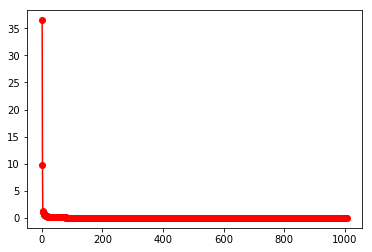

In [300]:
## Compute eigen-spectrum

x1 = np.linspace(1, NUM_NODES, NUM_NODES, endpoint=True)

plt.plot(x1, np.abs(w2), '-ro')


Chosen cut-off value is:  11


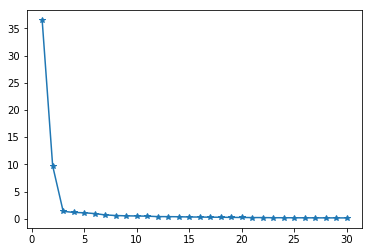

In [320]:

## Plot spectrum and indicate the cut-off value on the spectrum
# Quoting the paper, PCA one usally assumes tha t the directions corresponding
#to small eigenvalues contain the noise. Thus we can obtain a representation
# in a space of reduce dimension when choosing t< p dindmensions in 
#Xp= Vp(deltap)^(1/2)
# the vecitors in Rt differ from the vectror sin Rp in the sense of 
# quadratic error. The embedded vectors are the beast least squares error
# approximation to the optimal vectors whcih preserve the group structure

# The eigenvalue spectrum of the centered matrix Sc, shows that the
#highly negative entries don not derive from squared Distances. So
# we pcik the dominating directions in the embedding space.
# in my case 3 would be since the elbow is setted in p=3, however
#in question 5.5 : choose p > 3, for example, p = p_opt 
# so I will pick 11, since the eigenvalues asymptotically tend to zero
#from that p

#ZOOM
x1 = np.linspace(1,30,30, endpoint=True)
plt.plot(x1, w2[0:30],'-*')

## Determine a good cut-off value
p_opt = 11 ## change accordingly
print("Chosen cut-off value is: ", p_opt)

In [1]:
## FL: pretty fast drop... does not look right

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Perform K-MEANS algorithm on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. Plot the distance matrices for varying number of clusters K, both for the denoised ($p = p^*$ - from the previous step) and the original version as shown in figure 5 in [1]. To make the plots meaningful, sort the nodes according to the cluster belongings (see the figure 5). For now, there is no need to include the actual ground truth labels given in [2].
</p>

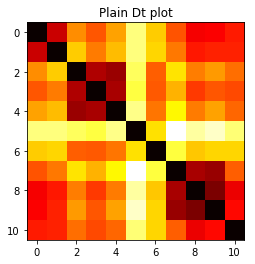

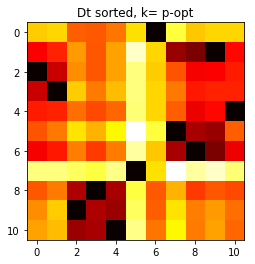

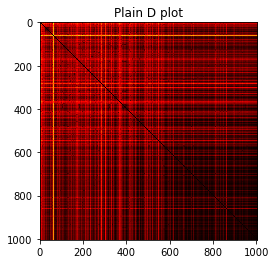

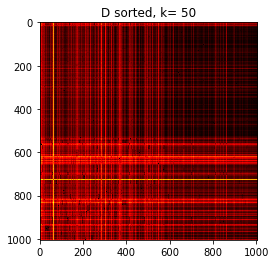

In [325]:

## Distance matrice
## Need to recalculate Dtilde for t.
nodes = p_opt
Dt = CSE.fit(DATA,nodes)
[Xpt, w2t] = CSE.get_embedded_vectors(Dt,nodes)

#################################################
kt = p_opt
k = 50
X = Xp.real
#clustering for t
y_pred = KMeans(n_clusters = p_opt, random_state = np.random.seed(42)).fit_predict(Xpt)
#clustering for all nodes=1005
y_pred1 = KMeans(n_clusters = k, random_state = np.random.seed(42)).fit_predict(X)

#sorting
yypredbig = np.matrix(y_pred1)
yypred = np.matrix(y_pred)
indexsort2 = np.argsort(yypredbig)
indexsort = np.argsort(yypred)

Dtsort = Dt[(indexsort),]
Dtsort1 = np.matrix(Dtsort)

Dsort = D[(indexsort2),]
Dsort1 = np.matrix(Dsort)


plt.imshow(Dt, cmap='hot', interpolation='nearest')
plt.title('Plain Dt plot')
plt.show()

plt.imshow(Dtsort1, cmap='hot', interpolation='nearest')
plt.title('Dt sorted, k= p-opt')
plt.show()


plt.imshow(D, cmap='hot', interpolation='nearest')
plt.title('Plain D plot')
plt.show()

plt.imshow(Dsort1, cmap='hot', interpolation='nearest')
plt.title('D sorted, k= 50')
plt.show()

In [ ]:
## Dt should still be a n x n matrix corresponding to euclidian distances of n points (embedded in p_opt features space!)

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    Now calculate the embeddings for p = 2, 3 and plot clusterings for a few values of K. Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Alternatively, you could use $p^*$ and then apply a dimensionality reduction technique to move to 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.
</p>

In [ ]:
## Get embeddings, run K-MEANS and generate plots
#1) p=2 + kmeans => 2d plot
#2) p=3 + kmeans => 3d plot
#3) p=p_opt  + kmeans + later PCA (or similar) to bring it to 2D => 2d plot

[0 1]
[[  2.78388218e+00   2.98023224e-08]
 [ -2.78388218e+00   2.98023224e-08]]


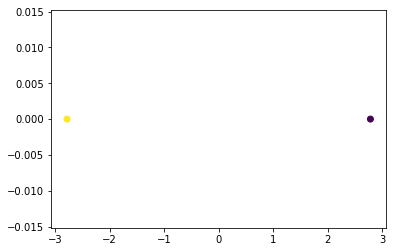

In [378]:
## p = 2
p = 2
nodes = p
Dt = CSE.fit(DATA,nodes)
[Xpt, w2t] = CSE.get_embedded_vectors(Dt,nodes)
Xpt = np.matrix(Xpt)
kt = 2
y_pred = KMeans(n_clusters = kt, random_state = np.random.seed(42)).fit_predict(Xpt)

print(y_pred)
print(Xpt)
xpt1 = np.array(Xpt[:,1])
xpt0 = np.array(Xpt[:,0])
plt.scatter(xpt0, xpt1, c = y_pred)




[[  2.66660373e+00   2.44298578e+00  -1.68832198e-08]
 [  2.90063859e+00  -2.02577340e+00  -2.35319818e-08]
 [  3.35503510e+00  -1.90292641e-01   3.37637694e-08]]


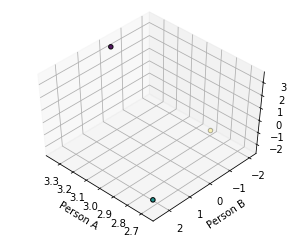

In [381]:
## p = 3
from mpl_toolkits.mplot3d import Axes3D

p = 3
nodes = p
Dt = CSE.fit(DATA,nodes)
[Xpt, w2t] = CSE.get_embedded_vectors(Dt,nodes)
kt = p
y_pred = KMeans(n_clusters = kt, random_state = np.random.seed(42)).fit_predict(Xpt)
print(Xpt)

fignum = 1
titles = ['3D']

fig = plt.figure(fignum, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
xpt1 = np.array(Xpt[:,1])
xpt0 = np.array(Xpt[:,0])
xpt2 = np.array(Xpt[:,2])

ax.scatter(xpt0, xpt1, xpt2, c = y_pred, edgecolor='k')

ax.set_xlabel('Person A')
ax.set_ylabel('Person B')
ax.set_zlabel('Person C')

[ 2  3  9  8 10  7  0  5  6  1  4]
[[-0.67957002  0.20176502]
 [-0.62790003  0.39499137]
 [ 0.82803611 -1.05528543]
 [ 0.49703175 -0.92798472]
 [ 0.80029277 -1.13983939]
 [ 1.87790734  1.79870001]
 [ 1.22224623  0.05899812]
 [-1.20041989  0.48355174]
 [-1.04843384  0.06425935]
 [-1.15407513  0.16813379]
 [-0.51511529 -0.04728985]]


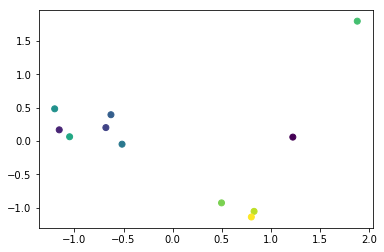

In [389]:
## choose p > 3, for example, p = p_opt 
## project computed p-dimentional embeddings onto 2-dimensional space using PCA, LL, t-SNE or something else
from sklearn.decomposition import PCA
from sklearn import decomposition
node = 11
p = 11
Dt = CSE.fit(DATA,nodes)
[Xpt, w2t] = CSE.get_embedded_vectors(Dt,nodes)
kt = p
y_pred = KMeans(n_clusters = kt, random_state = np.random.seed(42)).fit_predict(Xpt)
print(y_pred)

pca = decomposition.PCA(n_components = 2)
pca.fit(Xpt)
X = pca.transform(Xpt)
print(X)
xpt1 = np.array(X[:,1])
xpt0 = np.array(X[:,0])
plt.scatter(xpt0, xpt1, c = y_pred)

## add PCA



In [ ]:
## FL: why only such few points?

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2].
</p>

In [332]:
# Initialize community members affeliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

The true number of clusters (departments) is:  42


<p style="background-color:#adebad;">
Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?
</p>

In [390]:
D = CSE.fit(DATA,NUM_NODES)
[Xp, w2] = CSE.get_embedded_vectors(D,NUM_NODES)
X = Xp.real
k = 50
k_real = 42
y_DAC =  KMeans(n_clusters = k_real, random_state = np.random.seed(42)).fit_predict(X)
y_kmeans =  KMeans(n_clusters = k, random_state = np.random.seed(42)).fit_predict(X)

In [391]:
## Here you can provide plots and calculations
def postprocess(y_DAC, y_kmeans):
    """TODO: Add explanation"""
    
    y_DAC_hard = np.argmax(y_DAC, axis=1)
    
    n_clusters = len(np.unique(y_DAC_hard))
    dac2kmeans = []
    for cluster in range(n_clusters):
        argmax = np.argmax(y_DAC[:, cluster])
        dac2kmeans.append(y_kmeans[argmax])
        
    y_DAC_new = []
    for dac_label in y_DAC_hard:
        y_DAC_new.append(dac2kmeans[dac_label])
        
    return np.array(y_DAC_new)

In [395]:
from sklearn.metrics import confusion_matrix

#confusion_matrix(y_DAC, postprocess(y_DAC, y_kmeans))
confusion_matrix(y_DAC, y_kmeans)
# Isnot fully working, but i guess the difference score will be given by the postprocess function
# and with the k=50, we can compute a confusion matrix to evaluate the accuracy of the classfication




array([[19,  0,  0, ...,  0,  0,  0],
       [ 0,  6,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

Please, write here your explanations, observation and thoughts about results of the experiments above.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.